In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.models import Sequential

%matplotlib inline



rcParams['figure.figsize'] = 8, 5

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-19,6742.390137,6822.500000,6709.919922,6769.939941,6769.939941,4057029888
1,2018-06-20,6770.759766,6821.560059,6611.879883,6776.549805,6776.549805,3888640000
2,2018-06-21,6780.089844,6810.939941,6715.169922,6729.740234,6729.740234,3529129984
3,2018-06-22,6737.879883,6747.080078,6006.600098,6083.689941,6083.689941,5079810048
4,2018-06-23,6090.100098,6224.819824,6071.810059,6162.479980,6162.479980,3431360000


In [ ]:
df.shape

(1827, 7)

Text(0, 0.5, 'Close Price (USD)')

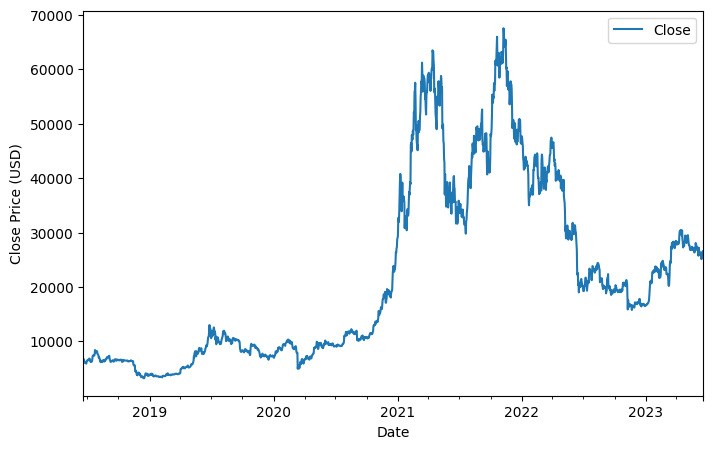

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

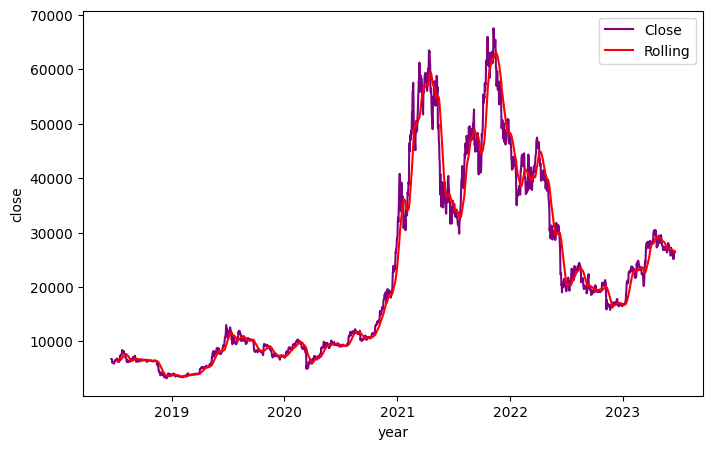

In [ ]:
close = df['Close'].rolling(20).mean()
plt.xlabel("year")
plt.ylabel("close")
plt.plot(df['Date'], df['Close'], color='purple')
plt.plot(df['Date'], close, color='red')
plt.legend(['Close','Rolling'])
plt.show()
df['Close'] = close

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(1827, 1)

In [ ]:
np.isnan(scaled_close).any()

True

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [ ]:
X_train.shape

(1537, 99, 1)

In [ ]:
y_train.shape

(1537, 1)

# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Activation

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


# Training

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
22/22 [==============================] - 14s 133ms/step - loss: 0.0161 - val_loss: 0.0103
Epoch 2/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0113 - val_loss: 6.8795e-04
Epoch 3/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0343 - val_loss: 0.0026
Epoch 4/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0377 - val_loss: 8.4522e-04
Epoch 5/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0349 - val_loss: 0.0194
Epoch 6/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0331 - val_loss: 0.0552
Epoch 7/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0146
Epoch 8/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0050 - val_loss: 4.4249e-04
Epoch 9/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0010 - val_loss: 1.

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 23ms/step - loss: 4.2102e-04


0.0004210193583276123

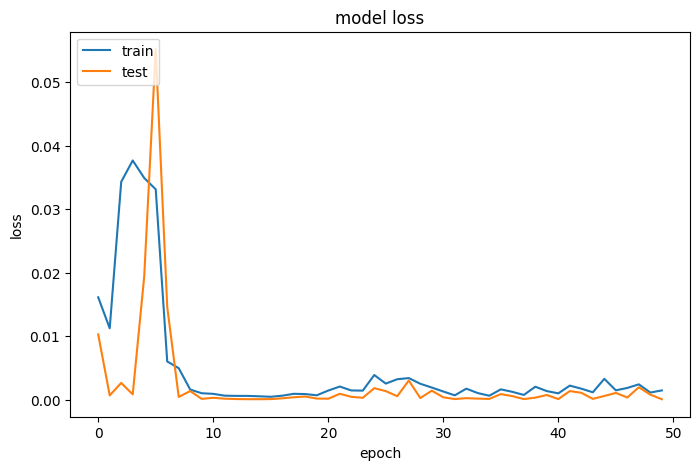

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

6/6 [==============================] - 2s 23ms/step


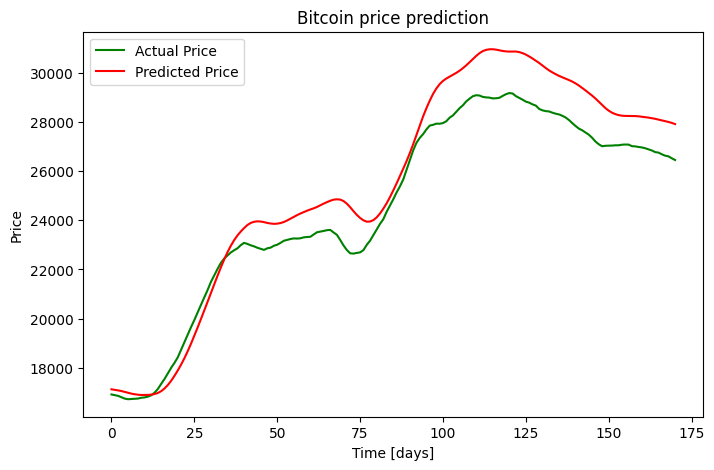

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [ ]:
def rmse(y1, y2):
  return np.sqrt(np.sum(np.square(y1-y2))/len(y1))

In [ ]:
rmse(y_hat_inverse, y_test_inverse)

1223.422228675104

In [ ]:
def getChange(y1, y2):
  y = y1-y2
  y = (y>0).astype(int)
  return y

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
def getError(target, predictions):
  # Calculate accuracy
  accuracy = accuracy_score(target, predictions)

  # Calculate precision
  precision = precision_score(target, predictions, average='macro')

  # Calculate recall
  recall = recall_score(target, predictions, average='macro')

  # Calculate F1 score
  f1 = f1_score(target, predictions, average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")


In [ ]:
l = len(y_hat_inverse)

In [ ]:
y_prediction = getChange(y_hat_inverse[0:l-1], y_hat_inverse[1:l])
y_actual = getChange(y_test_inverse[0:l-1], y_test_inverse[1:l])

In [ ]:
getError(y_actual, y_prediction)

Accuracy: 0.7705882352941177
Precision: 0.7635106828655216
Recall: 0.7720588235294117
F1 Score: 0.7655172413793103
